## Objective 2: To predict the probability of an incident becoming a managed incident to improve real time prioritization

### Importing required libraries

In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords

import seaborn as sns #Importing seaborn for viusalizations
from matplotlib import pyplot as plt

### Importing Data Set
#### uconn_dataset is the data provided for us

In [58]:
df_text = pd.read_excel('uconn_dataset.xlsx')

In [59]:
df_text.columns #Analyzing the list of columns

Index(['NUMBER', 'OPENED_AT', 'RESOLVED_AT', 'SYS_UPDATED_ON', 'STATE',
       'MAJOR_INCIDENT_STATE', 'ACTIVE', 'PRIORITY', 'SEVERITY', 'IMPACT',
       'U_SIM_ENGAGED', 'U_SIM_MANAGER_SYS_ID', 'LOCATION', 'PROMOTED_ON',
       'PROMOTED_BY_SYS_ID', 'PROPOSED_ON', 'PROPOSED_BY_SYS_ID',
       'CALLER_ID_SYS_ID', 'CONTACT_TYPE', 'U_INC_CAT', 'TAGS',
       'SHORT_DESCRIPTION', 'DESCRIPTION', 'U_TEMPLATE_USED', 'CLOSE_CODE',
       'U_RESOLUTION_CODE', 'U_TEAM_SPECIFIC_CODE', 'RESOLVED_BY_SYS_ID',
       'CMDB_CI', 'BUSINESS_SERVICE', 'ASSIGNMENT_GROUP', 'ASSIGNED_TO_SYS_ID',
       'CAUSED_BY', 'RFC', 'PARENT_INCIDENT', 'CHILD_INCIDENTS',
       'REOPEN_COUNT', 'REOPENED_BY_SYS_ID', 'REOPENED_TIME',
       'REASSIGNMENT_COUNT', 'U_OCC_ENGAGEMENT_METHOD'],
      dtype='object')

#### The following counts represents null values for each column

In [60]:
df_text.isna().sum()

NUMBER                          0
OPENED_AT                       0
RESOLVED_AT                 11101
SYS_UPDATED_ON                  0
STATE                           0
MAJOR_INCIDENT_STATE       327601
ACTIVE                          0
PRIORITY                       43
SEVERITY                        0
IMPACT                         44
U_SIM_ENGAGED                   0
U_SIM_MANAGER_SYS_ID       327768
LOCATION                   121538
PROMOTED_ON                327782
PROMOTED_BY_SYS_ID         327782
PROPOSED_ON                327922
PROPOSED_BY_SYS_ID         327924
CALLER_ID_SYS_ID                0
CONTACT_TYPE                 2127
U_INC_CAT                      15
TAGS                       326483
SHORT_DESCRIPTION               2
DESCRIPTION                    11
U_TEMPLATE_USED            293639
CLOSE_CODE                 197647
U_RESOLUTION_CODE           10461
U_TEAM_SPECIFIC_CODE        22583
RESOLVED_BY_SYS_ID         121739
CMDB_CI                      7337
BUSINESS_SERVI

#### combining text columns

In [61]:
df_text['concatenated_description']= df_text['SHORT_DESCRIPTION'] + df_text['DESCRIPTION']

In [62]:
df_text.head()

,NUMBER,OPENED_AT,RESOLVED_AT,SYS_UPDATED_ON,STATE,MAJOR_INCIDENT_STATE,ACTIVE,PRIORITY,SEVERITY,IMPACT,...,CAUSED_BY,RFC,PARENT_INCIDENT,CHILD_INCIDENTS,REOPEN_COUNT,REOPENED_BY_SYS_ID,REOPENED_TIME,REASSIGNMENT_COUNT,U_OCC_ENGAGEMENT_METHOD,concatenated_description
0,INC1319662,2021-05-31 10:12:19,2021-05-31 10:19:07,2021-06-14 11:00:10,Closed,NaN,False,3,3 - Low,3.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaT,0.0,NaN,MANAGEMENT AGENT LOSTDevice ciloracd2022 of ty...
1,INC1155199,2021-04-29 01:10:02,2021-04-29 01:13:07,2021-05-13 02:00:08,Closed,NaN,False,3,3 - Low,3.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaT,0.0,NaN,MANAGEMENT AGENT LOSTDevice cvwiisxp00180. of ...
2,INC0799260,2021-02-01 09:43:45,2021-02-01 09:52:07,2021-02-15 10:00:13,Closed,NaN,False,3,3 - Low,3.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaT,0.0,NaN,MANAGEMENT AGENT LOSTDevice <DOMAIN_NAME> of t...
3,INC0650904,2020-12-13 14:21:09,2020-12-14 12:34:26,2020-12-28 13:00:12,Closed,NaN,False,3,3 - Low,3.0,...,NaN,NaN,INC0651688,0.0,0.0,NaN,NaT,0.0,NaN,MANAGEMENT AGENT LOSTA Major alarm was generat...
4,INC1599254,2021-07-11 00:21:43,2021-07-11 02:56:16,2021-07-25 03:00:21,Closed,NaN,False,2,3 - Low,2.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaT,2.0,NaN,Synthetic failure -Specialty Script Gateway UR...


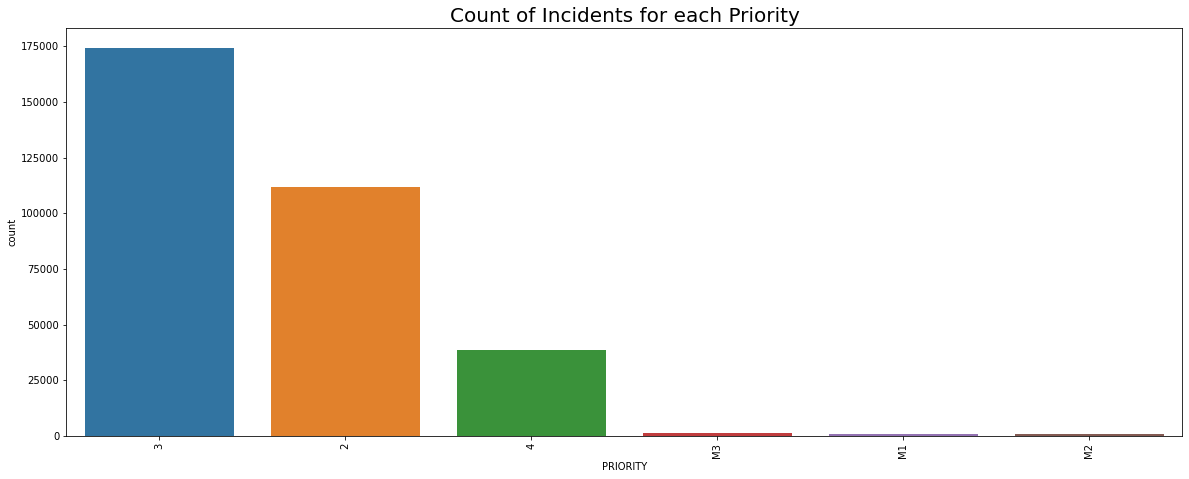

In [63]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p10 = sns.countplot(data=df_text,x='PRIORITY', order=df_text.PRIORITY.value_counts().iloc[:15].index) #count plot using sea born module
p10.set_xticklabels(p10.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p10.set_title("Count of Incidents for each Priority", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

In [64]:
df_text['Difference'] = (df_text['RESOLVED_AT'] - df_text['OPENED_AT']).astype('timedelta64[m]')

#### Outlier Analysis based on Difference column (Resolution Time)

<AxesSubplot:ylabel='Difference'>

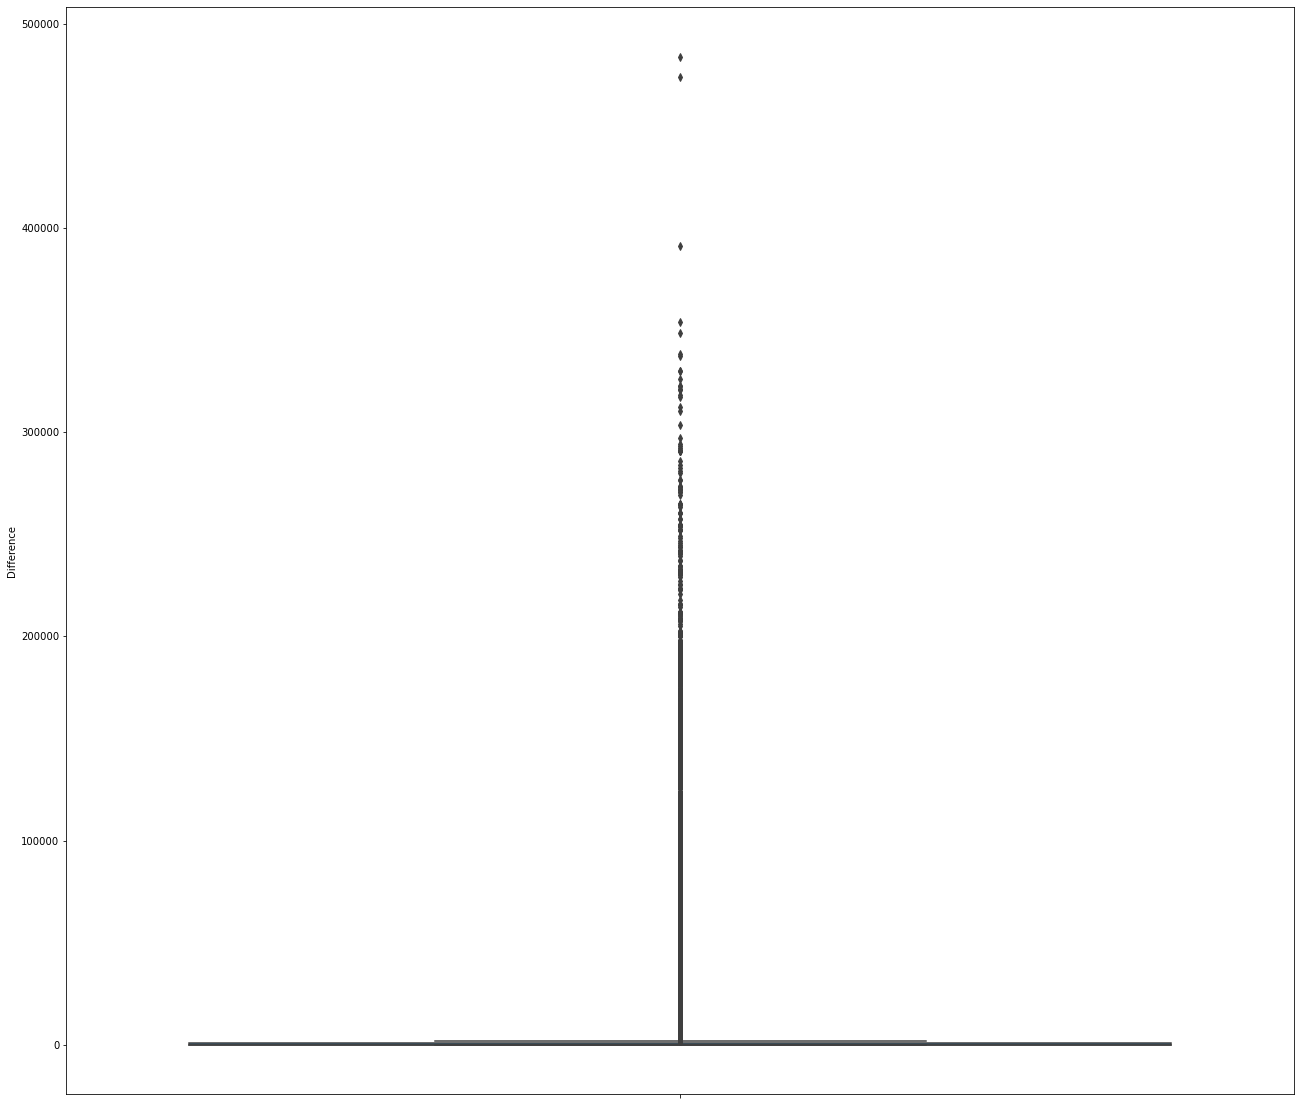

In [65]:
fig, axes = plt.subplots(1,1, figsize=(22,20)) #Preparing 8 sub plots with size 22, 20 

sns.boxplot(y=df_text["Difference"])

In [47]:
df_text.isnull().sum() #Checking Null values

NUMBER                           0
OPENED_AT                        0
RESOLVED_AT                  11101
SYS_UPDATED_ON                   0
STATE                            0
MAJOR_INCIDENT_STATE        327601
ACTIVE                           0
PRIORITY                        43
SEVERITY                         0
IMPACT                          44
U_SIM_ENGAGED                    0
U_SIM_MANAGER_SYS_ID        327768
LOCATION                    121538
PROMOTED_ON                 327782
PROMOTED_BY_SYS_ID          327782
PROPOSED_ON                 327922
PROPOSED_BY_SYS_ID          327924
CALLER_ID_SYS_ID                 0
CONTACT_TYPE                  2127
U_INC_CAT                       15
TAGS                        326483
SHORT_DESCRIPTION                2
DESCRIPTION                     11
U_TEMPLATE_USED             293639
CLOSE_CODE                  197647
U_RESOLUTION_CODE            10461
U_TEAM_SPECIFIC_CODE         22583
RESOLVED_BY_SYS_ID          121739
CMDB_CI             

## For detailed Data Exploration of Objective 2, Please refer to Objective 1 code file.

#### filtering priority column 2,3,4,M1,M2,M3 and ignoring blanks

In [48]:
df_1 = df_text[df_text['PRIORITY'].isin(['M3','M2','M1',2,3,4])]

In [49]:
df_1['PRIORITY'].unique()

array([3, 2, 4, 'M2', 'M3', 'M1'], dtype=object)

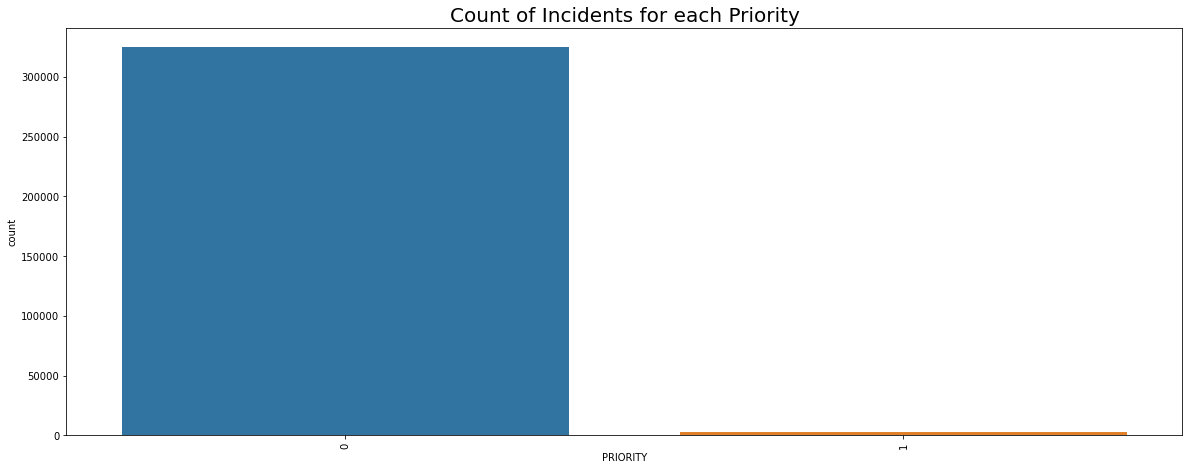

In [50]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p10 = sns.countplot(data=df,x='PRIORITY', order=df.PRIORITY.value_counts().iloc[:15].index) #count plot using sea born module
p10.set_xticklabels(p10.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p10.set_title("Count of Incidents for each Priority", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

#### Considering all rows for M3 and only nulls and accepted rows for M1, M2 priorities

#### Priorities with 2,3,4 values are grouped as 0 and M1, M2,M3 as 1. Converted the target variable PRIORITY as binary

In [51]:
df_f = df_1.replace({'PRIORITY':{2:0,3:0,4:0,'M3':1}})
df_final = df_f[~(df_f['PRIORITY'].isin(['M1','M2'])& df_f['MAJOR_INCIDENT_STATE'].isin(['Rejected', 'Canceled']))]
df_filtered = df_final.replace({'PRIORITY':{'M1':1,'M2':1}})

#### Dropping Insignificant Columns

In [52]:
#Initial analysis
#Initial analysis
df = df_filtered.drop([ 
         'SEVERITY', 
       'U_SIM_ENGAGED',
         'U_SIM_MANAGER_SYS_ID',  
         'PROMOTED_ON',
       'PROMOTED_BY_SYS_ID', \
         'PROPOSED_BY_SYS_ID',
       'CALLER_ID_SYS_ID', 
         'TAGS',
        'U_TEMPLATE_USED',
         'CLOSE_CODE',
       'U_RESOLUTION_CODE', 
         'U_TEAM_SPECIFIC_CODE',
         'RESOLVED_BY_SYS_ID',
       'CMDB_CI', 
         'ASSIGNED_TO_SYS_ID',
       'CAUSED_BY', 
         'RFC', 
         'REOPENED_BY_SYS_ID', 
         'REOPENED_TIME',
         'U_OCC_ENGAGEMENT_METHOD', 'OPENED_AT', 'RESOLVED_AT', 'SYS_UPDATED_ON', 'STATE',
       'MAJOR_INCIDENT_STATE', 'ACTIVE', 'IMPACT',
         'LOCATION', 'CONTACT_TYPE', 'U_INC_CAT',
       'SHORT_DESCRIPTION', 'DESCRIPTION',
       'BUSINESS_SERVICE', 'ASSIGNMENT_GROUP','CHILD_INCIDENTS',
       'REOPEN_COUNT',
       'REASSIGNMENT_COUNT','PROPOSED_ON', 'PARENT_INCIDENT'],  axis = 1)

In [53]:
df.columns

Index(['NUMBER', 'PRIORITY', 'concatenated_description', 'Difference'], dtype='object')

#### Drop Columns which has null values

In [54]:
df = df.dropna(subset=['concatenated_description'])
df = df.dropna(subset=['PRIORITY'])
df = df.dropna(subset=['NUMBER'])
print(df.shape) # now we have 48K rows
df.head()

(328180, 4)


,NUMBER,PRIORITY,concatenated_description,Difference
0,INC1319662,0,MANAGEMENT AGENT LOSTDevice ciloracd2022 of ty...,6.0
1,INC1155199,0,MANAGEMENT AGENT LOSTDevice cvwiisxp00180. of ...,3.0
2,INC0799260,0,MANAGEMENT AGENT LOSTDevice <DOMAIN_NAME> of t...,8.0
3,INC0650904,0,MANAGEMENT AGENT LOSTA Major alarm was generat...,1333.0
4,INC1599254,0,Synthetic failure -Specialty Script Gateway UR...,154.0


In [17]:
df.shape

(328180, 3)

#### Defining X and Y variables

In [56]:
df_text = df[['PRIORITY', 'concatenated_description','NUMBER']] #Y, X
df_text

,PRIORITY,concatenated_description,NUMBER
0,0,MANAGEMENT AGENT LOSTDevice ciloracd2022 of ty...,INC1319662
1,0,MANAGEMENT AGENT LOSTDevice cvwiisxp00180. of ...,INC1155199
2,0,MANAGEMENT AGENT LOSTDevice <DOMAIN_NAME> of t...,INC0799260
3,0,MANAGEMENT AGENT LOSTA Major alarm was generat...,INC0650904
4,0,Synthetic failure -Specialty Script Gateway UR...,INC1599254
...,...,...,...
328235,0,Used disk space on / percentage = 90% on Host...,INC1269292
328236,0,MANAGEMENT AGENT LOSTA Major alarm was generat...,INC0173447
328237,0,MANAGEMENT AGENT LOSTDevice QNJ1VBRP01.qualcar...,INC1286891
328238,0,Filenet id deletion greater that 365 daysPleas...,INC1149620


#### Reset_index function reset the index from 0 to n-1

In [21]:
df_text.reset_index(inplace=True, drop=True) #dropped exsisting collumn
df_text

,PRIORITY,concatenated_description,NUMBER
0,0,MANAGEMENT AGENT LOSTDevice ciloracd2022 of ty...,INC1319662
1,0,MANAGEMENT AGENT LOSTDevice cvwiisxp00180. of ...,INC1155199
2,0,MANAGEMENT AGENT LOSTDevice <DOMAIN_NAME> of t...,INC0799260
3,0,MANAGEMENT AGENT LOSTA Major alarm was generat...,INC0650904
4,0,Synthetic failure -Specialty Script Gateway UR...,INC1599254
...,...,...,...
328175,0,Used disk space on / percentage = 90% on Host...,INC1269292
328176,0,MANAGEMENT AGENT LOSTA Major alarm was generat...,INC0173447
328177,0,MANAGEMENT AGENT LOSTDevice QNJ1VBRP01.qualcar...,INC1286891
328178,0,Filenet id deletion greater that 365 daysPleas...,INC1149620


#### Inorder maintain the consistency, we converted entire concatenated description to lower case

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'
df_text['concatenated_description'] = df_text['concatenated_description'].str.lower()
df_text.head()

,PRIORITY,concatenated_description,NUMBER
0,0,management agent lostdevice ciloracd2022 of ty...,INC1319662
1,0,management agent lostdevice cvwiisxp00180. of ...,INC1155199
2,0,management agent lostdevice <domain_name> of t...,INC0799260
3,0,management agent losta major alarm was generat...,INC0650904
4,0,synthetic failure -specialty script gateway ur...,INC1599254


#### All characted other that alphabets (A-z) have been removed

In [23]:
df_text['concatenated_description'] = df_text['concatenated_description'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
df_text.head()

,PRIORITY,concatenated_description,NUMBER
0,0,management agent lostdevice ciloracd of type h...,INC1319662
1,0,management agent lostdevice cvwiisxp of type h...,INC1155199
2,0,management agent lostdevice domain_name of typ...,INC0799260
3,0,management agent losta major alarm was generat...,INC0650904
4,0,synthetic failure specialty script gateway url...,INC1599254


#### This is to print first three values and cross-check

In [24]:
print(df['concatenated_description'][0])
print(df['concatenated_description'][1])
print(df['concatenated_description'][2])

MANAGEMENT AGENT LOSTDevice ciloracd2022 of type Host_systemEDGE is no longer responding to primary management requests (e.g. SNMP), but appears to be responsive to other communication protocol (e.g. ICMP).This condition has persisted for an extended amount of time.An alarm will be generated.
MANAGEMENT AGENT LOSTDevice cvwiisxp00180. of type Host_systemEDGE is no longer responding to primary management requests (e.g. SNMP), but appears to be responsive to other communication protocol (e.g. ICMP).This condition has persisted for an extended amount of time.An alarm will be generated.
MANAGEMENT AGENT LOSTDevice <DOMAIN_NAME> of type Host_systemEDGE is no longer responding to primary management requests (e.g. SNMP), but appears to be responsive to other communication protocol (e.g. ICMP).This condition has persisted for an extended amount of time.An alarm will be generated.


#### We need to removed stop words like and, an, a, the which are not useful for the modeling. All the common words in nltk stopwords library are stored in variable stop. This is achived using Natural Language Tool Kit

In [25]:
# let's remove some of the stop words (see what happens if you comment this cell out)
# we can do better!
# define some stop words

nltk.download('stopwords') # this makes sure these are downloaded if you haven't already!

print('Here are the stop words we will delete!')
print(stopwords.words('english'))

stop = stopwords.words('english') # see why it's important to turn everything lower case? all of your stopwords are!

Here are the stop words we will delete!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not'

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1125)>


#### The following lamba function will delete all the stop words from concated description column

In [26]:
# this looks good! 
# ' '.join adds a nice space between the words after removing stop words

df_text["concatenated_description"] = df_text['concatenated_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
df_text.head()

,PRIORITY,concatenated_description,NUMBER
0,0,management agent lostdevice ciloracd type host...,INC1319662
1,0,management agent lostdevice cvwiisxp type host...,INC1155199
2,0,management agent lostdevice domain_name type h...,INC0799260
3,0,management agent losta major alarm generated s...,INC0650904
4,0,synthetic failure specialty script gateway url...,INC1599254


## Text Analytics
#### Analyzing the most common words occured in entire description column

In [27]:
# 1) what are the most common words in the ASSIGNMENT_GROUP? note that we are doing this before tokenizer
# you can also turn this into a bar plot!
myTable = df_text['concatenated_description'].str.split(expand=True).stack().value_counts()

In [28]:
myTable[0:10] # too cool! pick your own number!

alarm              381369
event              234488
generated          230037
soi                180267
device             175462
host_systemedge    157496
uptime             148984
agent              145023
time               138479
please             135845
dtype: int64

#### Tokenization is a way of separating a piece of text into smaller units called tokens. Each word will be seperated and stored as Tokens.

In [29]:

nltk.download('punkt')
df_text['concatenated_description'] = df_text.apply(lambda row: nltk.word_tokenize(row['concatenated_description']), axis=1)
df_text.head()

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1125)>


,PRIORITY,concatenated_description,NUMBER
0,0,"[management, agent, lostdevice, ciloracd, type...",INC1319662
1,0,"[management, agent, lostdevice, cvwiisxp, type...",INC1155199
2,0,"[management, agent, lostdevice, domain_name, t...",INC0799260
3,0,"[management, agent, losta, major, alarm, gener...",INC0650904
4,0,"[synthetic, failure, specialty, script, gatewa...",INC1599254


#### Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.
#### This cuts down on dimensionality
#### For example, the stem of the words eating, eats, eaten is eat.

In [30]:
# we won't use this today, but sure, it's possible to chop a word down
# this cuts down on dimensionality 
# using the example above, three words turn into one "connec"

# this is the function we will use
ps = PorterStemmer()

filtered_sent = df_text['concatenated_description'][0]

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:",filtered_sent)
print("Stemmed Sentence:",stemmed_words)

# in our example, we just got rid of "reported"

Filtered Sentence: ['management', 'agent', 'lostdevice', 'ciloracd', 'type', 'host_systemedge', 'longer', 'responding', 'primary', 'management', 'requests', 'eg', 'snmp', 'appears', 'responsive', 'communication', 'protocol', 'eg', 'icmpthis', 'condition', 'persisted', 'extended', 'amount', 'timean', 'alarm', 'generated']
Stemmed Sentence: ['manag', 'agent', 'lostdevic', 'ciloracd', 'type', 'host_systemedg', 'longer', 'respond', 'primari', 'manag', 'request', 'eg', 'snmp', 'appear', 'respons', 'commun', 'protocol', 'eg', 'icmpthi', 'condit', 'persist', 'extend', 'amount', 'timean', 'alarm', 'gener']


#### By applying lambda function, creating a new column with all the stemmed words and printing first few records

In [31]:
# if we wanted to, we could make a new column with just the stemmed words
# link: https://stackoverflow.com/questions/37443138/python-stemming-with-pandas-dataframe
df_text['Stemmed'] = df_text['concatenated_description'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.

In [32]:
df_text.head()

,PRIORITY,concatenated_description,NUMBER,Stemmed
0,0,"[management, agent, lostdevice, ciloracd, type...",INC1319662,"[manag, agent, lostdevic, ciloracd, type, host..."
1,0,"[management, agent, lostdevice, cvwiisxp, type...",INC1155199,"[manag, agent, lostdevic, cvwiisxp, type, host..."
2,0,"[management, agent, lostdevice, domain_name, t...",INC0799260,"[manag, agent, lostdevic, domain_nam, type, ho..."
3,0,"[management, agent, losta, major, alarm, gener...",INC0650904,"[manag, agent, losta, major, alarm, gener, soi..."
4,0,"[synthetic, failure, specialty, script, gatewa...",INC1599254,"[synthet, failur, specialti, script, gateway, ..."


#### The following user-defined function will help to re-join all stemmed words in the form of one single sentence. Once the transformation is done, we are printing top 5 values

In [33]:
def rejoin_words(row):
    my_list = row['Stemmed']
    joined_words = ( " ".join(my_list))
    return joined_words

df_text['Stemmed'] = df_text.apply(rejoin_words, axis=1)
# here it is after - no square brackets and commas!
df_text['Stemmed'].head()

0    manag agent lostdevic ciloracd type host_syste...
1    manag agent lostdevic cvwiisxp type host_syste...
2    manag agent lostdevic domain_nam type host_sys...
3    manag agent losta major alarm gener soi event ...
4    synthet failur specialti script gateway url ht...
Name: Stemmed, dtype: object

#### Creating two data frames (X,y) with X features and y features

In [35]:

X_LIST=['NUMBER','Stemmed']

X=pd.DataFrame(df_text[X_LIST])
y=df_text['PRIORITY']
print(X.shape,y.shape)

(328180, 2) (328180,)


#### Each model should be trained with training data and then we will evaluate the model with test data. So, We are assigning 70% of the data for training and 30% of the data for modeling using train_test_split function

In [38]:
#Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state = 123)

#### As we have three variables in the form of text format. We need to convert them in the form of vector and horizontally stack them using hstack function. Once we convert them in to vectorized format, the data will be stored as Sparse matrix.

#### Vectorizing Stemmed

In [39]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['Stemmed']) 
X_train_Description_tfidf=vectorizer.transform(X_train['Stemmed'].values) 
X_test_Description_tfidf=vectorizer.transform(X_test['Stemmed'].values) 
print("After vectorizations after Stemmed")
print(X_train_Description_tfidf.shape, y_train.shape) 
print(X_test_Description_tfidf.shape, y_test.shape)

After vectorizations after Stemmed
(229726, 12678) (229726,)
(98454, 12678) (98454,)


#### Checking records before sampling

In [316]:
# summarize class distribution
print("Before oversampling: ", Counter(y_test))

Before oversampling:  Counter({0: 97515, 1: 939})


In [317]:
# summarize class distribution
print("Before oversampling: ", Counter(y_train))

Before oversampling:  Counter({0: 181939, 1: 181929})


#### Applying OverSampling using SMOTE function

In [40]:
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = BorderlineSMOTE()

In [41]:
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_Description_tfidf, y_train)

#### train dataset rows after sampling

In [144]:
# summarize class distribution
print("After oversampling: ", Counter(y_train_over))

After oversampling:  Counter({0: 227418, 1: 227418})


#### Splitting the training data into training and validation data

In [42]:
from sklearn.model_selection import train_test_split

#100 - 60 and 40

#40 -  20 and 20

# 60% Training; 20% Validation; 20% Test
# text_counts is a SPARSE MATRIX!

X_train, X_val, y_train, y_val = train_test_split(X_train_over, y_train_over, 
                                                 test_size=0.2, 
                                                   shuffle=True,
                                                    random_state = 123)
print("done")

done


### Model - Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
clf = DecisionTreeClassifier(max_depth=24,criterion='gini').fit(X_train, y_train)

predicted_y_test= clf.predict(X_test_Description_tfidf)
print("DTC Accuracy (test):",metrics.accuracy_score(y_test, predicted_y_test))
predicted_y_val= clf.predict(X_val)
print("DTC Accuracy (val):",metrics.accuracy_score(y_val, predicted_y_val))


DTC Accuracy (test): 0.990604749426128
DTC Accuracy (val): 0.9933053381408847


#### predicting the probability of an incident of becoming a managed incident for X test data

In [ ]:
y=clf.predict_proba(X_test_Description_tfidf)                      

#### Concatinating Number, actual probability of test data(Priority) and predicted probability

In [153]:
X_test_df  = pd.DataFrame(X_test['NUMBER'], columns = ['NUMBER']).reset_index(drop=True)
X_test_df.head()

,NUMBER
0,INC1701989
1,INC0483890
2,INC0197147
3,INC1657187
4,INC1453342


In [156]:
y_test_df=pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df=pd.DataFrame(y).reset_index(drop=True)

In [157]:
final_df = pd.concat([X_test_df, y_test_df,  y_pred_df], axis=1)
final_df.head(10)

,NUMBER,PRIORITY,0,1
0,INC1701989,0,1.000000,0.000000
1,INC0483890,0,1.000000,0.000000
2,INC0197147,0,1.000000,0.000000
3,INC1657187,0,0.978388,0.021612
4,INC1453342,0,1.000000,0.000000
5,INC0649183,0,1.000000,0.000000
6,INC0159462,0,0.978388,0.021612
7,INC1294388,0,1.000000,0.000000
8,INC1544577,0,0.978388,0.021612
9,INC1279294,0,0.978388,0.021612


#### saving data to csv file

In [158]:
final_df.to_csv('sheetfinal.csv')

#### classification report

In [61]:

from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_y_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     97493
           1       0.08      0.88      0.15       954

    accuracy                           0.90     98447
   macro avg       0.54      0.89      0.55     98447
weighted avg       0.99      0.90      0.94     98447



#### Confusion Matrix table

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_y_test)

array([[87957,  9536],
       [  116,   838]])

### RANDOM FOREST CLASSIFIER

In [44]:
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
rf = RandomForestClassifier(n_estimators=20,random_state=0,criterion='gini',max_depth=30).fit(X_train, y_train)
rf_predicted_test= rf.predict(X_test_Description_tfidf)
print("RFC Accuracy (test):",metrics.accuracy_score(y_test, rf_predicted_test))
rf_predicted_val= rf.predict(X_val)
print("RFC Accuracy (val):",metrics.accuracy_score(y_val, rf_predicted_val))
rf_predicted_train= rf.predict(X_train)
print("RFC Accuracy (train):",metrics.accuracy_score(y_train, rf_predicted_train))
print("done")
# think of how much time this saves and we didn't even have
# to read any of this, just needed to be careful with our 
# data prep and let it rip!

RFC Accuracy (test): 0.9932151055315173
RFC Accuracy (val): 0.9889081874945036
RFC Accuracy (train): 0.9895401629162224
done


#### predicting the probability of an incident of becoming a managed incident for X test data

In [45]:
rf.predict_proba(X_test_Description_tfidf) 

array([[1.        , 0.        ],
       [0.94887988, 0.05112012],
       [0.98004402, 0.01995598],
       ...,
       [0.97972463, 0.02027537],
       [0.91555033, 0.08444967],
       [0.78014334, 0.21985666]])

### LOGISTIC REGRESSION

In [46]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1000.0,random_state=0,max_iter=5,solver='sag')
# fit the model - one line of code
LR = LR.fit(X_train, y_train)
predicted_y_test = LR.predict(X_test_Description_tfidf)
print("RFC Accuracy (test):",metrics.accuracy_score(y_test, predicted_y_test))
predicted_y_val = LR.predict(X_val)
print("RFC Accuracy (val):",metrics.accuracy_score(y_val, predicted_y_val))
predicted_y_train = LR.predict(X_train)
print("RFC Accuracy (train):",metrics.accuracy_score(y_val, predicted_y_val))

RFC Accuracy (test): 0.9917321794949926
RFC Accuracy (val): 0.996020578665025
RFC Accuracy (train): 0.996020578665025


/Users/ashimagupta/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


#### predicting the probability of an incident of becoming a managed incident for X test data

In [83]:
LR.predict_proba(X_test_Description_tfidf) 

array([[0.99533025, 0.00466975],
       [0.99005007, 0.00994993],
       [0.93387654, 0.06612346],
       ...,
       [0.99481417, 0.00518583],
       [0.99505241, 0.00494759],
       [0.90586995, 0.09413005]])